In [1]:
import json
import shutil
import os
from pathlib import Path

Please replace the \<group_name\> to your group name.

In [2]:
dir_path = '/project/<group_name>/screw-labeled'

We will turn the unlabeled data in the dataset into the folder `val`. This is based on what we labeled under label studio and turn it into the format that is easier for tensorflow to load.

In [3]:
data_path = '/datasets/screw/val'
data_val_good_path = os.path.join(data_path, 'good')
data_val_bad_path = os.path.join(data_path, 'bad')

p = Path(dir_path).glob('**/*')
files = [x for x in p if x.is_file()]

shutil.rmtree(data_path, ignore_errors=True)
os.makedirs(data_val_good_path, exist_ok=True)
os.makedirs(data_val_bad_path, exist_ok=True)

for file in files:
    f = open(file)
    data = json.load(f)
    file_path = '/' + data['task']['data']['image'].split('?d=')[-1]
    file_name = file_path.split('/')[-1]
    result = data['result'][0]['value']['choices'][0]
    if result == 'good':
        shutil.copyfile(file_path, os.path.join(data_val_good_path, file_name))
    else:
        shutil.copyfile(file_path, os.path.join(data_val_bad_path, file_name))
    f.close()
    
print('done')

done


In [4]:
!pip install tensorflow_hub

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image_dataset_from_directory

import mlflow
mlflow.set_experiment("tutorial_screw_train")
mlflow.tensorflow.autolog()

In [6]:
PATH = '/datasets/screw'

In [7]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

In [8]:
BATCH_SIZE = 8
IMG_SIZE = (1024, 1024)

In [9]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 79 files belonging to 2 classes.


In [10]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 20 files belonging to 2 classes.


Show some cases of training examples.

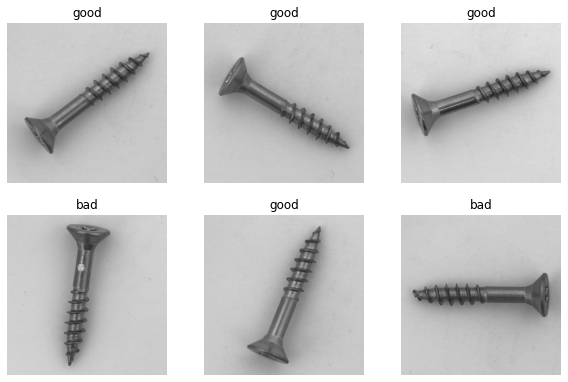

In [11]:
class_names = train_dataset.class_names

show_img = 1

if show_img:
    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(6):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
])

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"
base_model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
    hub.KerasLayer(model_url, trainable=False)
])
base_model.build([None, 224, 224, 3])

In [15]:
base_model.trainable = False

In [16]:
prediction_layer = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l2=0.1))

In [17]:
inputs = tf.keras.Input(shape=(1024, 1024, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
base_learning_rate = 0.01

In [19]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=base_learning_rate, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024, 1024, 3)]   0         
_________________________________________________________________
sequential (Sequential)      (None, 1024, 1024, 3)     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 1024, 1024, 3)     0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 1024, 1024, 3)     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1280)              4226432   
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,227,713
Trainable params: 1,281
Non-trainable params: 4,226,432
_______________________________________________

In [21]:
initial_epochs = 25

loss0, accuracy0 = model.evaluate(validation_dataset)

3/3 [==============================] - 3s 504ms/step - loss: 0.9373 - accuracy: 0.5719


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.95
initial accuracy: 0.55


In [23]:
def scheduler(epoch, lr):
    if epoch >= 10 and epoch % 10 == 0:
        return lr / 5
    return lr
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [24]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset, callbacks=[callback])

2021/07/07 09:54:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7a4c5a09327c4297a575cdf1709a933c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/25
10/10 [==============================] - 22s 1s/step - loss: 1.1070 - accuracy: 0.4430 - val_loss: 1.2197 - val_accuracy: 0.4500
Epoch 2/25
10/10 [==============================] - 15s 1s/step - loss: 0.8370 - accuracy: 0.6203 - val_loss: 0.6605 - val_accuracy: 0.5500
Epoch 3/25
10/10 [==============================] - 15s 1s/step - loss: 0.8759 - accuracy: 0.5696 - val_loss: 1.2574 - val_accuracy: 0.6500
Epoch 4/25
10/10 [==============================] - 15s 1s/step - loss: 0.7487 - accuracy: 0.6835 - val_loss: 0.5593 - val_accuracy: 0.9500
Epoch 5/25
10/10 [==============================] - 15s 1s/step - loss: 0.5980 - accuracy: 0.7848 - val_loss: 0.4932 - val_accuracy: 0.9500
Epoch 6/25
10/10 [==============================] - 15s 1s/step - loss: 0.4892 - accuracy: 0.8608 - val_loss: 0.5347 - val_accuracy: 0.8000
Epoch 7/25
10/10 [==============================] - 15s 1s/step - loss: 0.5843 - accuracy: 0.8354 - val_loss: 0.5990 - val_accuracy: 0.6500
Epoch 8/25
10/10 [==

Using TensorFlow backend.


INFO:tensorflow:Assets written to: /tmp/tmpoj2vdso9/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpoj2vdso9/model/data/model/assets


In [25]:
lossfinal, accuracyfinal = model.evaluate(validation_dataset)

3/3 [==============================] - 2s 498ms/step - loss: 0.4895 - accuracy: 0.9500


In [26]:
print("final loss: {:.2f}".format(lossfinal))
print("final accuracy: {:.2f}".format(accuracyfinal))

final loss: 0.49
final accuracy: 0.95
